<a href="https://colab.research.google.com/github/AzMax22/Stepik_DS_course/blob/main/Stepic_DS_contest_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from os import system
get_ipython().run_line_magic('matplotlib', 'inline')
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from IPython.display import HTML
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

Это Блокнот по проекту с [курса Data Science на Stepik](https://stepik.org/course/4852/)

Формулировка задачи здесь: https://stepik.org/lesson/226979/step/1?unit=199528

**Тренировочными данными** являються данные курса " Введение в анализ данных в R" **за все время**: [здесь](https://stepik.org/lesson/222124/step/3?unit=195045)

**Тестовыми данными являються**  являються данные курса "Анализ данных в R" за **первые два дня**:  [здесь](https://stepik.org/lesson/226979/step/1?unit=199528)

**Задача**: предсказать покинет курс пользователь или нет

#Скачиваем данные

`events_data` - данные о действиях, которые совершают студенты со стэпами \\

1. `step_id` - id стэпа
1. `user_id` - анонимизированный id юзера
1. `timestamp` - время наступления события в формате unix date
1. `action` - событие, возможные значения:
    * **discovered** - пользователь перешел на стэп
    * **viewed** - просмотр шага,
    * **started_attempt** - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
    * **passed** - удачное решение практического шага
----------------------------------------------------
`submissions_data` - данные о времени и статусах сабмитов к практическим заданиям

1. `step_id` - id стэпа
1. `timestamp` - время отправки решения в формате unix date
1. `submission_status` - статус решения
1. `user_id` - анонимизированный id юзера



In [2]:
sns.set(rc={'figure.figsize': (9,6)})

events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')

In [3]:
events_data.sample(5)

,step_id,timestamp,action,user_id
1261816,31955,1469614118,viewed,22377
1956572,32812,1490351706,started_attempt,4380
619481,33681,1437316722,viewed,25398
1605031,33894,1478823768,passed,25702
2518266,32795,1505681443,passed,18876


In [4]:
events_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480703 entries, 0 to 3480702
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   step_id    int64 
 1   timestamp  int64 
 2   action     object
 3   user_id    int64 
dtypes: int64(3), object(1)
memory usage: 106.2+ MB


In [5]:
events_data.user_id.nunique()

19234

In [6]:
submissions_data.sample(5)

,step_id,timestamp,submission_status,user_id
126969,33677,1447147997,wrong,26120
80962,32206,1436023496,correct,46
298251,31978,1491293160,wrong,19719
472735,32206,1523209031,wrong,25259
209024,33534,1481872991,correct,7899


In [7]:
submissions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509104 entries, 0 to 509103
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   step_id            509104 non-null  int64 
 1   timestamp          509104 non-null  int64 
 2   submission_status  509104 non-null  object
 3   user_id            509104 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 15.5+ MB


In [8]:
submissions_data.user_id.nunique()

9940

#  Предобработка данных

In [9]:
# adding days
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date

submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [10]:
events_data.head(3)


,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15


In [11]:
submissions_data.head(3)

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11


## Удалим тех пользователей , что еще проходят курс

Определим , что если челвек не посещал курс **30 дней** и не набрал 40 баллов считаеться **дропнувшим курс**.

Те кто набрал больше 40 баллов - **прошли курс**

Остальные пол-ватели еще **проходят курс** - удалим их из данных

In [12]:
drop_thresh = 30 * 24 * 60 * 60
now = events_data.timestamp.max()

In [13]:
last_appear = events_data.groupby("user_id").timestamp.max()
last_appear.head()

,timestamp
user_id,
1,1472827464
2,1519226966
3,1444581588
5,1499859939
7,1521634660


In [14]:
gone_course = (now - last_appear > drop_thresh) \
                                    .astype(int) \
                                    .rename("is_gone")
gone_course

,is_gone
user_id,
1,1
2,1
3,1
5,1
7,1
...,...
26790,1
26793,1
26794,1


In [15]:
gone_course.value_counts()

,count
is_gone,
1,17844
0,1390


Удалим данные о тех кто еще проходит курс.

In [16]:
to_del = gone_course[gone_course == 0].index
to_del

Index([   11,    24,    25,    32,    34,    57,    77,    78,   149,   156,
       ...
       26495, 26501, 26543, 26558, 26569, 26619, 26659, 26661, 26673, 26708],
      dtype='int64', name='user_id', length=1390)

In [17]:
events_data = events_data[~events_data.user_id.isin(to_del)]
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [18]:
events_data.user_id.nunique()

17844

In [19]:
submissions_data = submissions_data[~submissions_data.user_id.isin(to_del)]
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [20]:
submissions_data.user_id.nunique()

8986

## Проверка на уникальность "correct" для одного задания для одного пользователя в бд

Проверим , могут ли существовать несколько "correct"
 у одного пользователя на один степ в бд  

In [21]:
test_corr_uniq = submissions_data.query("submission_status == 'correct'") \
                .groupby(["user_id"]) \
                .agg({"step_id": "nunique", "submission_status": "count"})
test_corr_uniq.sample(5)

,step_id,submission_status
user_id,,
15204,14,17
15200,8,8
4709,9,15
14231,28,28
5113,8,8


In [22]:
(test_corr_uniq.step_id == test_corr_uniq.submission_status).value_counts()

,count
True,7201
False,1646


!!! **Значит на одно задание от одного пользователя может быть несколько "correct" ответов в бд**

Пример:

In [23]:
submissions_data.query("user_id == 14995").groupby("step_id").submission_status.value_counts()

,,count
step_id,submission_status,


## event_data_train

`event_data_train` - будет содержать действия п-ля за первые **2** дня (48ч) прохождения курса.

Профильтруем `events_data`, оставив события только за первые 2 дня, для каждого п-ля

In [24]:
interval = 2 * 24 * 60 * 60
interval

172800

In [25]:
# get threshold for each person
start_time = events_data.groupby("user_id").timestamp.min()
thresholds = start_time + interval
thresholds.head()

,timestamp
user_id,
1,1473000264
2,1514556164
3,1434531276
5,1466329609
7,1521807460


In [26]:
events_data_train = events_data[events_data.timestamp <= events_data.user_id.map(thresholds)]
events_data_train

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
...,...,...,...,...,...,...
3358880,32815,1524150524,discovered,3620,2018-04-19 15:08:44,2018-04-19
3358881,32815,1524150524,viewed,3620,2018-04-19 15:08:44,2018-04-19
3359545,32950,1524163176,passed,6466,2018-04-19 18:39:36,2018-04-19
3359546,32950,1524163176,discovered,6466,2018-04-19 18:39:36,2018-04-19


Проверим, что данные храняться о действиях за 2 дня (48ч). Ответ должен быть 3 тк макс 48ч могут быть в течении 3х дней

In [27]:
events_data_train.groupby("user_id").day.nunique().max()

3

Проверим что не мотеряли пользователей:

In [28]:
events_data_train.user_id.nunique()

17844

## submissions_data_train

`submissions_data_train` - содержит ответы за задачи п-ля за первые **2** дня прохождения курса.

Код аналогичен `event_data_train`

In [29]:
submissions_data_train = submissions_data[submissions_data.timestamp <= submissions_data.user_id.map(thresholds)]
submissions_data_train

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
5,31976,1434348188,correct,15853,2015-06-15 06:03:08,2015-06-15
7,31977,1434347371,correct,15853,2015-06-15 05:49:31,2015-06-15
...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06


Проверка

In [30]:
submissions_data_train.groupby('user_id').day.nunique().max()

3

In [31]:
submissions_data_train.user_id.nunique()

8067

Стало меньше пол-лей в `submissions_data_train` так как отбросились данные о тех пользователях , которые отправили первое задание позже 2х дней

## X и y

В `X` будут находиться фичи пользователя, за первые **2 дня** его обучения на `stepik`

Фичи:
1. `days` - количество уник. дней на курсе (1, 2, 3)
1. `steps_tried` - кол-во степов, кот. пробовал решить пол-ль
1. `correct` - кол-во верных попыток на пр. зад (пока НЕ уник.)
1. `wrong` - кол-во неверных попыток пр. зад (пока НЕ уник.)
1. `correct_ratio` - отношение `correct` / (`correct` +` wrong`)
1. `viewed` - кол-во просметренных степов

In [32]:
X = events_data_train.groupby('user_id').day.nunique() \
                     .rename("days")
X = X.to_frame()

In [33]:
X.head()

,days
user_id,
1,1
2,1
3,1
5,1
7,1


In [34]:
X.days.value_counts()

,count
days,
1,13323
2,3098
3,1423


`y` - будет хранить целевую переменную, прошел пользователь курс в итоге или нет

Добавим сколько степов человек попытался решить за первые 2 дня

In [35]:
steps_tried = submissions_data_train.groupby('user_id').step_id \
                                    .nunique()  \
                                    .rename('steps_tried')

In [36]:
steps_tried.head()

,steps_tried
user_id,
2,2
3,4
8,11
14,1
16,18


In [37]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [38]:
X.head()

,days,steps_tried
user_id,,
1,1,NaN
2,1,2.0
3,1,4.0
5,1,NaN
7,1,NaN


Добавим число правильных и неправильных попыток и отношение правильности к неправильности.

In [39]:
users_scores = submissions_data_train.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0) \
                        .rename_axis(columns=None)
users_scores.head()

,correct,wrong
user_id,,
2,2,0
3,4,4
8,9,21
14,0,1
16,18,23


In [40]:
X = X.merge(users_scores, on='user_id', how='outer')
X = X.fillna(0).map(int)


In [41]:
X.head()

,days,steps_tried,correct,wrong
user_id,,,,
1,1,0,0,0
2,1,2,2,0
3,1,4,4,4
5,1,0,0,0
7,1,0,0,0


In [42]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)
X = X.fillna(0)

In [43]:
X.head()

,days,steps_tried,correct,wrong,correct_ratio
user_id,,,,,
1,1,0,0,0,0.0
2,1,2,2,0,1.0
3,1,4,4,4,0.5
5,1,0,0,0,0.0
7,1,0,0,0,0.0


Добавим сколько у нас было просмотрено степов суммарно

In [44]:
pivot_events_data = events_data_train.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).rename_axis(columns=None)
pivot_events_data.head()

,discovered,passed,started_attempt,viewed
user_id,,,,
1,1,0,0,1
2,9,9,2,9
3,15,15,4,20
5,1,1,0,1
7,1,1,0,1


In [45]:
X = X.merge(pivot_events_data.viewed, on="user_id" ,how='outer')

In [46]:
X.sample(5)

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
4399,1,2,2,0,1.0,3
20039,1,0,0,0,0.0,1
22302,1,0,0,0,0.0,1
22066,1,0,0,0,0.0,1
2359,3,4,4,1,0.8,96


In [47]:
X = X.fillna(0)

Создадим `y`

По условию задания прошел курс те , кто решил **больше 40 практ. заданий**

In [48]:
users_correct_steps = submissions_data.query("submission_status == 'correct'") \
                                      .groupby("user_id").step_id.nunique()
users_correct_steps.head()

,step_id
user_id,
2,2
3,29
5,2
8,9
16,76


In [49]:
users_passed_course = (users_correct_steps > 40).map(int)
users_passed_course = users_passed_course.rename("passed_course")
users_passed_course

,passed_course
user_id,
2,0
3,0
5,0
8,0
16,1
...,...
26787,0
26790,0
26794,0


Есть те кто вообще ничего не присылали, и значит курс тоже не прошли. Обозначим их тоже 0

In [50]:
X_y = X.merge(users_passed_course, on="user_id", how="outer")
X_y = X_y.fillna(0)
X_y

,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course
user_id,,,,,,,
1,1,0,0,0,0.000000,1,0.0
2,1,2,2,0,1.000000,9,0.0
3,1,4,4,4,0.500000,20,0.0
5,1,0,0,0,0.000000,1,0.0
7,1,0,0,0,0.000000,1,0.0
...,...,...,...,...,...,...,...
26790,1,0,0,0,0.000000,2,0.0
26793,1,0,0,0,0.000000,1,0.0
26794,2,22,24,7,0.774194,90,0.0


In [51]:
y = X_y["passed_course"].astype(int)
y.head()

,passed_course
user_id,
1,0
2,0
3,0
5,0
7,0


Итого:

In [52]:
X

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
1,1,0,0,0,0.000000,1
2,1,2,2,0,1.000000,9
3,1,4,4,4,0.500000,20
5,1,0,0,0,0.000000,1
7,1,0,0,0,0.000000,1
...,...,...,...,...,...,...
26790,1,0,0,0,0.000000,2
26793,1,0,0,0,0.000000,1
26794,2,22,24,7,0.774194,90


In [57]:
y.sample(5)

,passed_course
user_id,
15086,0
634,0
25781,0
16629,0
202,1


In [54]:
y.value_counts()

,count
passed_course,
0,16137
1,1707


In [55]:
X.shape, y.shape

((17844, 6), (17844,))

# Обучение модели

## Дерево решений

In [62]:
clf = DecisionTreeClassifier()


param_grid =  {'criterion': ["gini", "entropy"], \
               'min_samples_split':range(100, 1001, 100), \
               'max_depth':range(10, 101, 10), \
               'min_samples_leaf':range(100, 1001, 100)}

search = RandomizedSearchCV(clf, param_grid, scoring="roc_auc", verbose=2)

search.fit(X, y)

best_tree = search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END criterion=gini, max_depth=90, min_samples_leaf=1000, min_samples_split=600; total time=   0.0s
[CV] END criterion=gini, max_depth=90, min_samples_leaf=1000, min_samples_split=600; total time=   0.0s
[CV] END criterion=gini, max_depth=90, min_samples_leaf=1000, min_samples_split=600; total time=   0.0s
[CV] END criterion=gini, max_depth=90, min_samples_leaf=1000, min_samples_split=600; total time=   0.0s
[CV] END criterion=gini, max_depth=90, min_samples_leaf=1000, min_samples_split=600; total time=   0.0s
[CV] END criterion=entropy, max_depth=80, min_samples_leaf=600, min_samples_split=700; total time=   0.0s
[CV] END criterion=entropy, max_depth=80, min_samples_leaf=600, min_samples_split=700; total time=   0.0s
[CV] END criterion=entropy, max_depth=80, min_samples_leaf=600, min_samples_split=700; total time=   0.0s
[CV] END criterion=entropy, max_depth=80, min_samples_leaf=600, min_samples_split=700; total time=   

In [63]:
search.best_params_

{'min_samples_split': 200,
 'min_samples_leaf': 400,
 'max_depth': 50,
 'criterion': 'gini'}

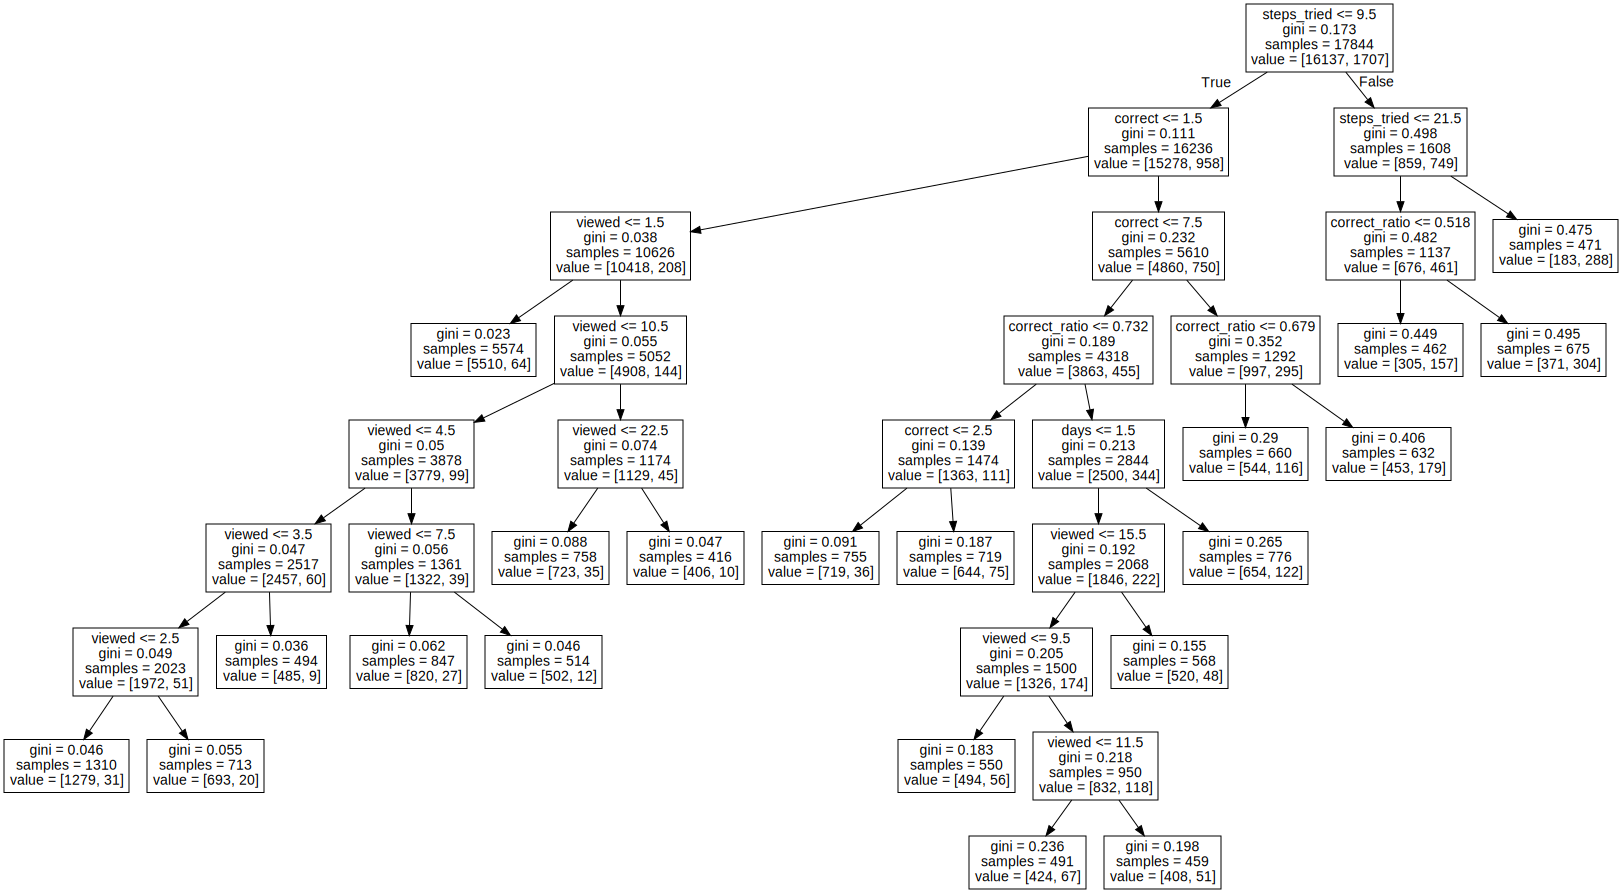

In [64]:
Source(export_graphviz(best_tree, feature_names=X.columns))

In [65]:
res = pd.DataFrame(search.cv_results_)
res = res.loc[:,~res.columns.str.endswith("time")]
res = res.loc[:,~res.columns.str.startswith("split")]
res.drop(columns=["params"], inplace=True)

In [66]:
res.sort_values(by="rank_test_score").head(20)

,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,mean_test_score,std_test_score,rank_test_score
9,200,400,50,gini,0.844095,0.010843,1
8,800,100,70,gini,0.843355,0.010318,2
7,900,500,10,entropy,0.842832,0.010601,3
3,300,400,20,entropy,0.842680,0.010595,4
5,700,400,30,entropy,0.842680,0.010595,4
6,700,900,70,gini,0.842181,0.010747,6
0,600,1000,90,gini,0.841914,0.010870,7
1,700,600,80,entropy,0.841605,0.008574,8
2,1000,700,20,gini,0.841276,0.010741,9
4,1000,1000,50,entropy,0.840471,0.009407,10


# Предсказание тестовой выборки

## Скачиваем данные

In [68]:
events_data_test = pd.read_csv('https://stepik.org/media/attachments/course/4852/events_data_test.csv')
submissions_data_test = pd.read_csv('https://stepik.org/media/attachments/course/4852/submission_data_test.csv')

In [69]:
events_data_test.sample(5)

,step_id,timestamp,action,user_id
54033,31983,1537468335,discovered,20770
170526,120744,1536051034,discovered,16047
195275,31957,1540189107,discovered,21901
178866,31955,1537125512,discovered,14505
221353,31958,1544388851,passed,10549


In [71]:
events_data_test.user_id.nunique()

6184

In [72]:
submissions_data_test.sample(5)

,step_id,timestamp,submission_status,user_id
7434,31988,1528388223,wrong,19603
24167,32219,1538179948,correct,18840
41123,32812,1539015325,wrong,2869
3109,31971,1527707604,correct,24681
19363,32031,1534595475,wrong,11984


In [73]:
submissions_data_test.user_id.nunique()

2803

## Аналогично выделим фичи для `X_test`

Фичи:
1. `days` - количество уник. дней на курсе (1, 2, 3)
1. `steps_tried` - кол-во степов, кот. пробовал решить пол-ль
1. `correct` - кол-во верных попыток на пр. зад (пока НЕ уник.)
1. `wrong` - кол-во неверных попыток пр. зад (пока НЕ уник.)
1. `correct_ratio` - отношение `correct` / (`correct` +` wrong`)
1. `viewed` - кол-во просметренных степов

In [76]:
# adding days to DB
events_data_test['date'] = pd.to_datetime(events_data_test.timestamp, unit='s')
events_data_test['day'] = events_data_test.date.dt.date

submissions_data_test['date'] = pd.to_datetime(submissions_data_test.timestamp, unit='s')
submissions_data_test['day'] = submissions_data_test.date.dt.date

In [77]:
#days
X_test = events_data_test.groupby('user_id').day.nunique() \
                     .rename("days")
X_test = X_test.to_frame()

In [82]:
#steps_tried
steps_tried = submissions_data_test.groupby('user_id').step_id \
                                    .nunique()  \
                                    .rename('steps_tried')

X_test = X_test.merge(steps_tried, on='user_id', how='outer')

In [85]:
# correct/wrong
users_scores = submissions_data_test.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0) \
                        .rename_axis(columns=None)

X_test = X_test.merge(users_scores, on='user_id', how='outer')
X_test = X_test.fillna(0).map(int)

In [87]:
# correct_ratio
X_test['correct_ratio'] = X_test.correct / (X_test.correct + X_test.wrong)
X_test = X_test.fillna(0)

In [89]:
# viewed
pivot_events_data = events_data_test.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).rename_axis(columns=None)

X_test = X_test.merge(pivot_events_data.viewed, on="user_id" ,how='outer')
X_test = X_test.fillna(0)

Итого:

In [91]:
X_test

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
4,1,0,0,0,0.000000,1
6,1,0,0,0,0.000000,1
10,1,0,0,0,0.000000,6
12,1,1,1,0,1.000000,14
13,2,29,29,36,0.446154,105
...,...,...,...,...,...,...
26791,1,0,0,0,0.000000,1
26795,1,0,0,0,0.000000,1
26796,1,2,2,3,0.400000,12


## Делаем предсказание `y_pred`

In [117]:
y_pred = pd.Series(best_tree.predict_proba(X_test)[:,1], index=X_test.index, name="is_gone")
y_pred.head()

,is_gone
user_id,
4,0.011482
6,0.011482
10,0.031877
12,0.046174
13,0.611465


<Axes: >

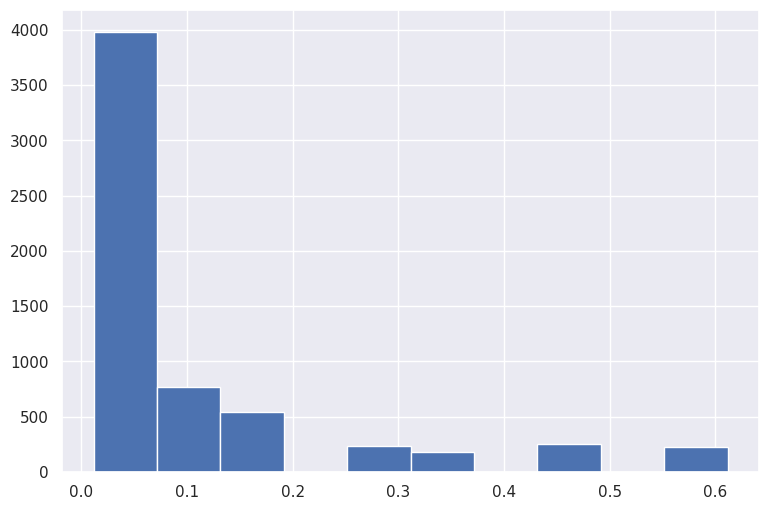

In [113]:
y_pred.hist()

In [118]:
y_pred.to_csv("./y_pred.csv")

In [116]:
y_pred.shape

(6184,)

# Результат

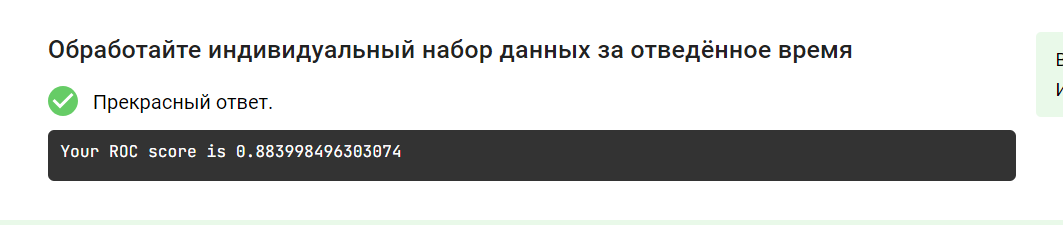

Your ROC score is 0.883998496303074

# Задачи

## 1.[Найти степ после которого п-ли покидают курс](https://stepik.org/lesson/223834/step/7?unit=196653)

In [119]:
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')
submissions_data

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
...,...,...,...,...
509099,120745,1501946959,wrong,2615
509100,120745,1503059927,correct,13177
509101,120745,1506348153,wrong,15253
509102,120745,1523035316,wrong,1424


In [120]:
submissions_data.user_id.nunique()

9940

In [121]:
 hard_steps = submissions_data.loc[submissions_data.groupby("user_id")["timestamp"].idxmax()]
 hard_steps

,step_id,timestamp,submission_status,user_id
506853,32812,1514383485,correct,2
114961,33538,1444573728,correct,3
505569,32812,1499859730,correct,5
500024,33332,1480604143,correct,8
509054,33983,1436368601,wrong,14
...,...,...,...,...
491467,32219,1469015051,correct,26787
508280,32929,1451722691,correct,26790
318273,32812,1511374868,correct,26794
506152,32812,1508425828,correct,26797


In [122]:
ans = hard_steps[hard_steps.submission_status == "wrong"].step_id.value_counts().keys()[0]
print("Ответ: ", ans)

Ответ:  31978
